In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import datetime
import copy
import scipy
import sklearn.metrics
import ImageDataset

plt.ion()   # interactive mode

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((100,150), scale = [0.8,1]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop((100,150), scale = [0.8,1]),
        transforms.ToTensor()
    ]),
}

LOG_DIR = 'logs'
if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)
log_fname='log_output'+ datetime.datetime.now().strftime('%Y-%m-%d_%H-%M') +'.txt'
LOG_FOUT = open(os.path.join(LOG_DIR, log_fname), 'w')    

start_time = time.time()
prev_end_time = start_time

GeForce RTX 2070 SUPER


Take the Pre-trained Model and Tranfer
----------------------

set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>__.



In [2]:
def log_string(*args):
    out_str = ' '.join(map(str, args))
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)

def get_elapsed_time(stime):
    total_secs = int(time.time()-stime)
    hours = total_secs//(60*60)
    leftover_secs = total_secs % (60*60)
    minutes = leftover_secs//60
    seconds = leftover_secs % 60
    return hours,minutes,seconds
        
def print_elapsed_time(intro='',stime=start_time):
    global prev_end_time
    hours_sec,minutes_sec,seconds_sec = get_elapsed_time(prev_end_time)
    hours,minutes,seconds = get_elapsed_time(stime)
    log_string('------- ' + intro +  ' -------')
    log_string('------- run time: section: %d hours, %d minutes, %d seconds, total: %d hours, %d minutes, %d seconds -------\n' % (hours_sec, minutes_sec, seconds_sec, hours, minutes, seconds))
    prev_end_time = time.time()    
    
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        log_string('Epoch {}/{}'.format(epoch, num_epochs - 1))
        log_string('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            log_string('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        log_string()

    time_elapsed = time.time() - since
    log_string('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log_string('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def consensus_vote(cur_vote,x):
    if cur_vote == 0 and sum(x) == len(x):
        return 1
    if cur_vote == 1 and sum(x) == 0:
        return 0
    return cur_vote



def test_model(model,dataloader,visualize=False):
    dataset_size = len(dataloader)//2
    y_pred_first_val = np.zeros((dataset_size,1))
    y_pred_majority = np.zeros((dataset_size,1))
    y_pred_consensus = np.zeros((dataset_size,1))
    y_true = np.zeros((dataset_size,1))
    i = 0
    cur_vote = 0
    model.eval() 
    for inputs,labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        prediction = torch.argmax(model(inputs),dim=1)
        prediction = prediction.cpu().data.numpy().reshape([-1,1])
        labels = labels.cpu().data.numpy().reshape([-1,1])
        cur_vote = consensus_vote(cur_vote,prediction)
        y_pred_consensus[i] = cur_vote
        y_pred_majority[i] = scipy.stats.mode(prediction)[0][0][0]
        y_pred_first_val[i] = prediction[0]
        y_true[i] = labels[0]
        i+=1
        if i >= dataset_size:
            break
    if visualize:
        t = np.array(range(0,dataset_size*5,5))/3600
        plt.figure(figsize=(9, 3))

        plt.subplot(311)
        plt.plot(t, y_true)
        plt.subplot(312)
        plt.plot(t, y_pred_first_val)
        plt.subplot(313)
        plt.plot(t, y_pred_consensus)
        plt.suptitle('Smoothing')
        plt.show()
    
    f1_first_val = sklearn.metrics.f1_score(y_true, y_pred_first_val, average='macro')
    f1_majority = sklearn.metrics.f1_score(y_true, y_pred_majority, average='macro')
    f1_consensus = sklearn.metrics.f1_score(y_true, y_pred_consensus, average='macro')
    return f1_first_val, f1_majority, f1_consensus

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.


data loaded with classes: ['not_laying', 'laying']


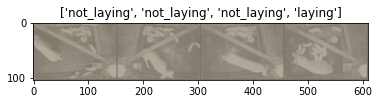

In [3]:
data_dir = 'D:\\Google Drive\\Pig Labeled Frames\\subsampled\\'


detect_laying = True
image_datasets = {x: ImageDataset.TrainImageFolder(os.path.join(data_dir, x), detect_laying,transform=data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
log_string('data loaded with classes:',class_names)

# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Train Model
---------

load and transfer with pre-trained model


In [4]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

#save model:
model_path_lay = 'D:\\Google Drive\\Pig Labeled Frames\\models\\laying\\laying_model_apr2_subsamp'
model_path_nurse = 'D:\\Google Drive\\Pig Labeled Frames\\models\\laying\\nursing_model_apr2_subsamp'

if detect_laying:
    torch.save(model_conv, model_path_lay)
else:
    torch.save(model_conv, model_path_nurse)
print_elapsed_time(intro='train time:',stime=start_time)

log_string('validating model with balanced data...')
f1_first_val, f1_majority, f1_consensus = test_model(model_conv,dataloaders['val'])

log_string('f1 score (no vote, as data is not in order):',f1_first_val)


Epoch 0/14
----------


KeyboardInterrupt: 

Test and Visualize Model
---------

first on balanced test set, then with a whole day


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
data_dir = 'D:\\Google Drive\\Pig Labeled Frames\\cage2\\'
#data_dir = 'D:\\Google Drive\\Pig Labeled Frames\\subsampled\\val\\'
print_elapsed_time(intro='so far:')

if detect_laying:
    model = torch.load(model_path_lay)
else:
    model = torch.load(model_path_nurse)

#detect_laying = True
test_dataset = ImageDataset.TrainImageFolder(data_dir, detect_laying,to_sort=1,transform= data_transforms['val'])


test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25,
                                             shuffle=False, num_workers=0)

                                             
class_names = test_dataset.classes
log_string('loaded test data with classes:',class_names)

log_string('testing model with unbalanced data...')
f1_first_val, f1_majority, f1_consensus = test_model(model,test_dataloader,visualize=True)
log_string('no vote f1 score:',f1_first_val,'majority vote f1 score:',f1_majority,'consensus vote f1 score:',f1_consensus)
print_elapsed_time(intro='testing time:')


test_dataset = ImageDataset.TrainImageFolder(data_dir, detect_laying,to_sort=-1,transform= data_transforms['val'])


test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25,
                                             shuffle=False, num_workers=0)

                                             
class_names = test_dataset.classes
log_string('loaded test data with classes:',class_names)

log_string('testing model with unbalanced data...')
f1_first_val, f1_majority, f1_consensus = test_model(model,test_dataloader,visualize=True)
log_string('no vote f1 score:',f1_first_val,'majority vote f1 score:',f1_majority,'consensus vote f1 score:',f1_consensus)
print_elapsed_time(intro='testing time:')




laying all day:
no vote 2 accuracy: 0.8570360214383647 majority vote accuracy: 0.8570360214383647 consensus vote accuracy: 0.8752752234166559

In [ ]:
log_string('no vote f1 score:',f1_first_val,'majority vote f1 score:',f1_majority,'consensus vote f1 score:',f1_consensus)


In [ ]:
if 0:
    print('true')